# Scrape the Fact Check archived page (https://www.abc.net.au/news/factcheck/browse/?nw=0) to collect all the articles url and identify which of them have a tweet as a source¶

## In the archived page, the fact check articles are categorised as follows:

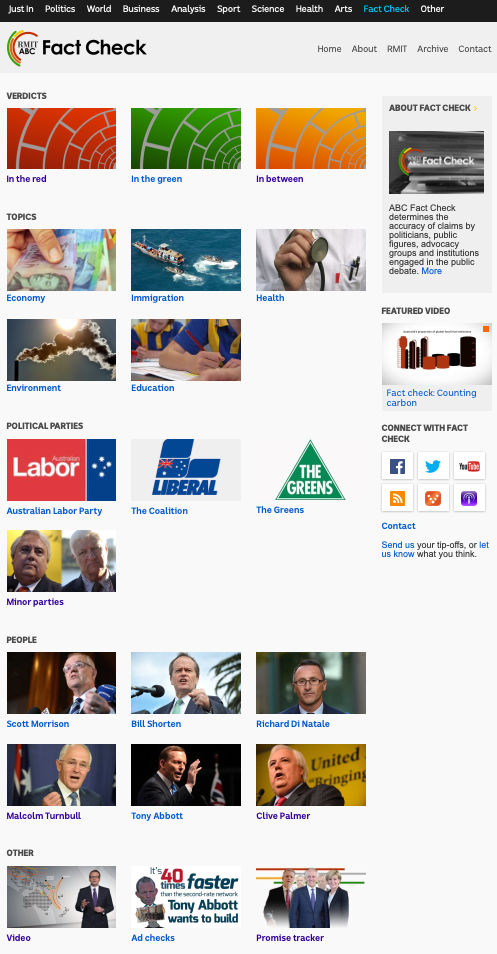

## To extract all the articles url, we do as follows:
### 1. Idenfity the categories urls
### 2. Extract the articles url from each category

In [1]:
from utils import *

In [2]:
## this list will contain all (i.e., from each category) the fact check url articles to scrape later when searching for a tweet source
articles_url_to_scrape = []

# this list will store the category of the article (e.g.,  in the red, economy, the greens)
articles_type = []

In [3]:
main_url = "https://www.abc.net.au/news/factcheck/browse/?nw=0"
prefix_url = "https://www.abc.net.au"
main_response = requests.get(main_url)
main_soup = BeautifulSoup(main_response.text, "html.parser")

## 1. Identify the categories' url

In [4]:
non_scrape = ['video','ad-checks','promisetracker','contact'] ## these categories are not useful for our main task
articles_type_url_to_scrape = []
all_articles_type = main_soup.find_all("article")
for article_type in all_articles_type:
    all_textlinks = article_type.find_all("div", {"class": "view-textlink"})
    for txtlink in all_textlinks:
        all_a = txtlink.find_all("a", href=True)
        for a in all_a:
            article_type_url_to_scrape = a['href']
            if article_type_url_to_scrape.split("/")[3] not in non_scrape:
                cur_article_type_url_to_scrape = prefix_url + article_type_url_to_scrape
                print(cur_article_type_url_to_scrape)
                articles_type_url_to_scrape.append(cur_article_type_url_to_scrape)

https://www.abc.net.au/news/factcheck/in-the-red/
https://www.abc.net.au/news/factcheck/in-the-green/
https://www.abc.net.au/news/factcheck/in-between/
https://www.abc.net.au/news/factcheck/economy/
https://www.abc.net.au/news/factcheck/immigration/
https://www.abc.net.au/news/factcheck/health/
https://www.abc.net.au/news/factcheck/environment/
https://www.abc.net.au/news/factcheck/education/
https://www.abc.net.au/news/factcheck/alp/
https://www.abc.net.au/news/factcheck/coalition/
https://www.abc.net.au/news/factcheck/greens/
https://www.abc.net.au/news/factcheck/minor-parties/
https://www.abc.net.au/news/factcheck/scott-morrison/
https://www.abc.net.au/news/factcheck/bill-shorten/
https://www.abc.net.au/news/factcheck/richard-di-natale/
https://www.abc.net.au/news/factcheck/malcolm-turnbull/
https://www.abc.net.au/news/factcheck/tony-abbott/
https://www.abc.net.au/news/factcheck/clive-palmer/


## 2. Extract the articles url from each category

In [5]:
for article_type_url in articles_type_url_to_scrape[:]: #iterate through each of the categories
    article_type = article_type_url.split("/")[5]
    print('article type:', article_type)
    end_reached = False #each category url may have more than one page, use this flag to identify the last page reached on each category
    next_page_url = ""
    while (not end_reached):
        print('\tpage: ', next_page_url)
        url_to_use = article_type_url + next_page_url
        article_type_response = requests.get(url_to_use)
        article_type_soup = BeautifulSoup(article_type_response.text, "html.parser")

        all_articles = article_type_soup.find_all("ul", {"class": "article-index"})
        for article in all_articles:
            all_headers = article.find_all("h3")
            for header in all_headers:
                all_a = header.find_all("a", href=True)
                for a in all_a:
                    article_url_to_scrape = prefix_url + a['href']
                    if article_url_to_scrape not in articles_url_to_scrape:
                        articles_url_to_scrape.append(article_url_to_scrape)
                        articles_type.append(article_type)
                        
        print('\tcurrent number of articles to scrape: ', len(articles_url_to_scrape))
        
        navigation_div = article_type_soup.find_all("div", {"class": "nav pagination"})
        if len(navigation_div) > 0:
            next_page_class = navigation_div[0].find_all("a", {"class": "next"})
            if len(next_page_class) > 0:
                next_page_url = next_page_class[0]['href']
            else:
                end_reached = True
        else:
            end_reached = True

article type: in-the-red
	page:  
	current number of articles to scrape:  50
	page:  ?page=2
	current number of articles to scrape:  100
	page:  ?page=3
	current number of articles to scrape:  144
article type: in-the-green
	page:  
	current number of articles to scrape:  192
	page:  ?page=2
	current number of articles to scrape:  241
	page:  ?page=3
	current number of articles to scrape:  264
article type: in-between
	page:  
	current number of articles to scrape:  312
	page:  ?page=2
	current number of articles to scrape:  362
	page:  ?page=3
	current number of articles to scrape:  410
	page:  ?page=4
	current number of articles to scrape:  458
	page:  ?page=5
	current number of articles to scrape:  498
article type: economy
	page:  
	current number of articles to scrape:  507
	page:  ?page=2
	current number of articles to scrape:  511
	page:  ?page=3
	current number of articles to scrape:  516
	page:  ?page=4
	current number of articles to scrape:  519
	page:  ?page=5
	current numbe

# At the moment we have collected all the urls from fact check articles in the archived page. Next step is to identify which of them come from a tweet source.

In [6]:
print("Total number of urls to scrape: ", len(articles_url_to_scrape))

Total number of urls to scrape:  693


## Search for tweet source information in the list of articles url to scrape

In [7]:
has_tweet_source = []
location_tweet_source = []
all_quoted_claims = []
all_original_tweets = []
for article_url_to_scrape in articles_url_to_scrape:
    print(article_url_to_scrape)
    response = requests.get(article_url_to_scrape)
    soup = BeautifulSoup(response.text, "html.parser")
    
    metas = soup.find_all('meta')
    published_time = extractFromMeta(metas, "published_time")
    if published_time != "":
        since_tstamp, until_tstamp = getSinceUntilTimestamps(published_time, 2)

        text_in_claim = getTextInClaim(soup) #Extract the text in "The Claim" section
        state, where_in_text = hasTweetSource(text_in_claim)
        quoted_claims = re.findall(r'"(.*?)"', text_in_claim)
        original_tweets = getOriginalTweets(quoted_claims, since_tstamp, until_tstamp, 50)
    else:
        state = "Error while scraping article url. Check article format"
        where_in_text =  ["Error while scraping article url. Check article format"]
        quoted_claims = ["Error while scraping article url. Check article format"]
        original_tweets = ["Error while scraping article url. Check article format"]
        
    has_tweet_source.append(str(state))
    location_tweet_source.append(where_in_text)
    all_quoted_claims.append(quoted_claims)
    all_original_tweets.append(original_tweets)
    
    print('\t' + str(state))
    print("where in text: ", where_in_text)
    print("quoted claims: ", quoted_claims)
    print("original tweets: ", original_tweets)
    print("\n")

https://www.abc.net.au/news/2020-10-28/fact-check-queensland-unemployment-before-covid-19-coronavirus/12782678
	False
where in text:  
quoted claims:  ["When you've had four consecutive years of the highest unemployment rate in the nation — and this was before COVID — Queenslanders deserve a government that has an economic plan to drag Queensland out of the recession and get people into jobs,", 'Queensland has had the worst unemployment record in Australia for the last four years thanks to Labor.']
original tweets:  ['Quoted claim exceeds 280 characters', 'No tweets found']


https://www.abc.net.au/news/2020-10-01/fact-check-was-victorias-lockdown-most-severe-oustide-wuhan/12690432
	False
where in text:  
quoted claims:  ['health dictatorship', 'extraordinary ineptitude', 'responded to with the most severe lockdown tried anywhere in the world outside of Wuhan itself']
original tweets:  ['www.twitter.com/kerrberr74/status/1306148993248960512', 'www.twitter.com/GrallertM/status/129174514

	False
where in text:  
quoted claims:  ["What's really scary is this Government's cut nearly $2 billion from aged-care services."]
original tweets:  ['No tweets found']


https://www.abc.net.au/news/2019-03-22/fact-check-nsw-votes-solar-power-usage/10919640
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2019-03-18/fact-check-nsw-election-school-closures-openings-daley/10892542
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2019-03-15/fact-check-dutton-refugees-ho

	False
where in text:  
quoted claims:  ['special attention', 'there is a very serious situation developing in South Africa. Something like 400 white farmers have been murdered, brutally murdered, over the last 12 months', 'In the last year more than 400 white farmers have been killed.']
original tweets:  ['www.twitter.com/CitywatchBot/status/981295159257202693', 'www.twitter.com/themarkjacka/status/975550396427988992', 'No tweets found']


https://www.abc.net.au/news/2018-03-23/fact-check-over-the-counter-prescription-only-codeine/9522916
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2018-03-20/fact-check-flora-and-fauna-1967-referendum/9550650
	True
where in text:  ['Twitter to suggest this claim should be fact-checked.']

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2016-06-02/fact-check-are-there-over-a-million-457s-out-there/7463706
	False
where in text:  
quoted claims:  ["We have over a million 457s out there, and that's another reason why we don't have jobs here,", 'out there']
original tweets:  ['No tweets found', 'www.twitter.com/AltPixarDad/status/737963400689528832']


https://www.abc.net.au/news/2016-05-13/fact-check-bill-shorten-budget-2016/7400702
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


h

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2015-02-11/fact-check3a-did-labor-cut-246.6-billion-from-higher-educatio/5952452
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2015-02-04/hockey-tax/6066142
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Che

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-06-02/chris-bowen-scaremongering-on-commissions-for-financial-advisers/5430672
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-05-13/tony-shepherd-incorrect-doctor-visits/5436706
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error w

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2013-11-26/barry-ofarrell-wrong-on-proceeds-of-crime/5088132
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2013-11-21/chris-bowen-wrong-self-education-expenses/5099582
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping artic

	False
where in text:  
quoted claims:  ["Josh's party hasn't even submitted one policy for costing yet... to the Parliamentary Budget Office..."]
original tweets:  ['No tweets found']


https://www.abc.net.au/news/2020-11-19/fact-check-humanities-science-graduates-uni-fee-changes/12822186
	False
where in text:  
quoted claims:  ['job-ready graduates', 'incentivise students to make more job-relevant choices', 'People who do humanities degrees and social science degrees get jobs at about exactly the same rate as science graduates,']
original tweets:  ['www.twitter.com/GregoryDEvans/status/1315537300642824193', 'No tweets found', 'No tweets found']


https://www.abc.net.au/news/2020-08-13/fact-check-budget-debt-coronavirus-pandemic/12545628
	False
where in text:  
quoted claims:  ['eye watering numbers around debt and deficit', 'The coronavirus has required the Government to spend unprecedented amounts of money to support people in need', 'pull a swiftie', 'Something like two-thirds of t

	True
where in text:  ['Twitter followers thatthe spiritual stakes are highfor employers who rip-off their workers: "The Pope is making @unionsaustralia look soft on wage theft.']
quoted claims:  ["The Pope is making @unionsaustralia look soft on wage theft. He's declared it a mortal sin so punishment is eternal"]
original tweets:  ['www.twitter.com/sallymcmanus/status/1000178833205571589']


https://www.abc.net.au/news/2018-05-25/fact-check-has-foreign-aid-budget-been-cut-five-years-running/9783098
	True
where in text:  ['tweeted: "This year\'s budget is the fifth year in a row that the Australian Government has cut Australian aid.']
quoted claims:  ["continuing Australia's darkest era of aid cuts and further letting down the world's most vulnerable", 'Not content with having cut lifesaving aid in its previous four budgets, this government has singled out cuts to aid yet again', "This year's budget is the fifth year in a row that the Australian Government has cut Australian aid."]
ori

	False
where in text:  
quoted claims:  ["We have more species of higher  plants than 94 per cent of countries on Earth, and more non-fish vertebrate animals  than 95 per cent of the world's countries,", 'We have more species of mammals than 93 per cent of countries, more birds than 79 per cent of countries, more amphibians than 95 per cent of countries, and more reptiles than any other country on Earth.', 'About 85 per cent of flowering plants, 84 per cent of mammals, more than 45 per cent of birds, and 89 per cent of inshore, freshwater fish are endemic,']
original tweets:  ['No tweets found', 'Quoted claim exceeds 280 characters', 'No tweets found']


https://www.abc.net.au/news/2015-08-12/china-free-trade-agreement-cost-australian-jobs-fact-check/6653214
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2015-08-10/solar-coverage-fact-check-is-australia-sunniest-continent/6659316
	False
where in text:  
quoted claims:  ['the solar resource

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-07-27/emissions-reduction-fund-promise-check/5430108
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-07-27/judicial-inquiry-union-governance-corruption-promise-check/5494732
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while 

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-04-08/whaling-around-the-world-how-japans-catch-compares/5361954
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-03-31/children-in-detention-is-australia-breaching-international-law/5344022
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:

	False
where in text:  
quoted claims:  ["works with Australian governments to help promote the development of the nation's oil and gas resources in a manner that maximises the return to the Australian industry and community", "There are few people in Australia with such a comprehensive understanding of Australia's oil and gas industry.", 'providing strategic advice', 'skills and contacts', 'What I will be looking for is to develop the mining sector with Seven Group,']
original tweets:  ['No tweets found', 'No tweets found', 'www.twitter.com/Talented365/status/374198724484169728', 'www.twitter.com/JayDT7/status/366476002068676608', 'No tweets found']


https://www.abc.net.au/news/2013-09-30/gas-shortages-nsw-macfarlane/4980952
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Che

	False
where in text:  
quoted claims:  ['fossil fuel extraction and production of energy', "There's no subsidisation of Australia's fossil fuel industries,"]
original tweets:  ['No tweets found', 'No tweets found']


https://www.abc.net.au/news/2020-07-16/fact-check-are-there-no-cuts-to-abc-funding/12417226
	False
where in text:  
quoted claims:  ["If you look at the numbers in the budget papers, the ABC's funding is rising. It's all laid out in the budget papers."]
original tweets:  ['No tweets found']


https://www.abc.net.au/news/2020-06-17/fact-check-wa-emergency-powers-vaccination-covid-19/12349842
	True
where in text:  ["tweet includes a screenshot of Western Australia's declaration of a public health state of emergency and two screenshots that are untitled but mirror the wording of the WA Public Health Act.", 'tweet.', 'tweet was then shared in the Facebook group99% unite Main Group "it\'s us or them"which is popular with anti-vaccination supporters and had more than 60,000 mem

	False
where in text:  
quoted claims:  ["What we don't have in Australia is a law that basically says that you cannot discriminate against someone because of their religious beliefs,", "It does seem to be a bit of a missing link in our legal regime, that there's currently not that protection in place that says that you cannot discriminate against someone because of what they believe in,"]
original tweets:  ['No tweets found', 'Quoted claim exceeds 280 characters']


https://www.abc.net.au/news/2019-08-20/are-marks-to-get-into-teaching-getting-lower-and-lower/11387970
	True
where in text:  ['tweetto say "the quality of some teaching degrees is simply not good enough", and that action must be taken to "raise the standard".']
quoted claims:  ['the quality of some teaching degrees is simply not good enough', 'raise the standard', 'Marks to get into teaching are getting lower + lower,']
original tweets:  ['No tweets found', 'www.twitter.com/bonhoefferchild/status/1162105590732267520', 'No 

	True
where in text:  ['tweeton February 26 that: "In 2014, the Liberals & Nationals cut $20 million from specialist domestic violence shelters.']
quoted claims:  ['In 2014, the Liberals & Nationals cut $20 million from specialist domestic violence shelters.', 'heartless government … over the last eight years.']
original tweets:  ['www.twitter.com/michaeldaleyMP/status/1100523691295666178', 'No tweets found']


https://www.abc.net.au/news/2019-03-01/fact-check-medevac-refugees-offshore-coleman/10839222
	False
where in text:  
quoted claims:  ['medevac bill', 'very, very low threshold', 'We expect that in short order substantially everyone will come to Australia,', "The bill doesn't even require people to be sick … All that's required is that somebody says that it's necessary that  come to Australia for assessment."]
original tweets:  ['www.twitter.com/etbalitaree/status/1099814781458964480', 'No tweets found', 'No tweets found', 'No tweets found']


https://www.abc.net.au/news/2019-02-

	False
where in text:  
quoted claims:  ['stop shagging men', 'slut-shaming', "It's critical to understand that the position of women in Australia has regressed quite dramatically in the last six or eight years.", ' she said.']
original tweets:  ['www.twitter.com/LucyHMRoche/status/1017529919054778370', 'www.twitter.com/TheSakuraKid/status/1028418034178904064', 'No tweets found', 'www.twitter.com/MissC_1717/status/1028592727154454528']


https://www.abc.net.au/news/2018-08-03/fact-check-sugar-consumption-and-obesity/9999182
	False
where in text:  
quoted claims:  ['Sugar consumption is down but obesity is up,', "It's the same in the US: obesity has more than doubled since 1990 while sugar intake fell. Clearly, neither sugar, nor drinks sweetened with sugar, were the major cause of this obesity rise.", "just 2 per cent of the average Australian's kilojoule intake comes from soft drinks", 'little or no return in obesity reduction.']
original tweets:  ['No tweets found', 'No tweets found'

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2018-02-28/fact-check-did-the-tasmanian-liberals-cut-210m-from-health/9483130
	False
where in text:  
quoted claims:  ["The Liberals cut $210 million from the health budget. Under the Liberals you're on your own,"]
original tweets:  ['No tweets found']


https://www.abc.net.au/news/2018-02-19/fact-check-the-public-service-and-woolworths/9404588
	False
where in text:  
quoted claims:  ['Of course, that figure includes state and local public sector workers. Narrow things down to the federal level, and there are more people working for Woolworths than in the public service.']
original tweets:  ['No tweets found']


https://www.abc.net.au/news/2017-12-13/fact-check-kristina-keneally

	True
where in text:  ['tweeted about pets and foreign aid.']
quoted claims:  ["I was just told that 'As a county  we spent 3 x more on our pets last year than we did on foreign aid.' So I did a check. Yep — that's true,", 'Obviously no relation. It does highlight just how small overall expenditure on aid is — despite the oft outcry.  2  of my own).']
original tweets:  ['www.twitter.com/samdastyari/status/900988727257739264', 'No tweets found']


https://www.abc.net.au/news/2017-09-08/fact-check-the-high-court-and-dual-citizenship-scandal/8874064
	False
where in text:  
quoted claims:  ['he High Court, for them to be eligible, will have to actually change the current interpretation,', "On the current interpretation, all of these members were citizens of another country and they didn't take reasonable steps to get rid of that citizenship. That makes them ineligible."]
original tweets:  ['No tweets found', 'No tweets found']


https://www.abc.net.au/news/2017-08-30/fact-check-mining-boom

	False
where in text:  
quoted claims:  ['It is incontestable that gun-related homicides have fallen quite significantly in Australia, incontestable.', "74 per cent fall in the gun-related suicide rates, isn't that evidence?"]
original tweets:  ['www.twitter.com/EdwardJWHunter/status/709161688516276225', 'No tweets found']


https://www.abc.net.au/news/2016-04-15/fact-check-abcc-and-industrial-disputes-michaelia-cash/7310994
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2016-03-31/is-a-tobacco-excise-increase-a-workers-tax/7245264
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article

	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2015-10-16/does-uber-need-the-laws-to-change-fact-check/6846512
	False
where in text:  
quoted claims:  [" don't need to spend hundreds of thousands, they just need to pay the basic minimal regulatory costs..."]
original tweets:  ['No tweets found']


https://www.abc.net.au/news/2015-10-09/fact-check-women-running-big-companies/6783082
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2015-10-08/suicide-rates-road-toll-john-brogden-fact-check/6822324
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2015-09-18/is-bombing-in-syria-illegal-fact-check/6765386
	False
where in text:  
quoted claims:  ['to maintain international peace and security', "That's because Russia and possibly China would invoke their veto if the other states wanted to craft a resolution for the coalition to use force against IS in Syria,

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2015-03-02/childcare-funding-cuts/6253304
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2015-02-13/hockey-100-million/6085378
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://w

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-09-10/young-childless-women-earn-more-than-men-fact-check/5712770
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-08-15/joe-hockey-poor-people-cars-claim-misleading/5671168
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while s

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-07-27/686-million-to-finish-the-perth-gateway-promise-check/5505064
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-07-27/40-million-to-establish-a-reef-trust-promise-check/5455126
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-07-27/bowel-cancer-screening-promise-check/5518270
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-07-08/does-anzus-commit-us-to-come-to-australias-aid-fact-check/5559288
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scr

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2019-03-04/analysis-claims-labor-big-tax-policies-misleading/10861688
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2018-02-15/fact-check-was-2017-strongest-calendar-year-jobs/9356526
	False
where in text:  
quoted claims:  ['2017 was a year of extraordinary jobs growth in Australia, over 400,000 jobs created in the year', 'That was the strongest calendar growth in jobs we have seen on record,']
original tweets:  ['No tweets found', 'No tweets found']


https://www.abc.net.au/news/2017-06-20/fact-check-pauline-hanson-bank-levy-tax-turnbull-budget/8591552
	False
where in text:  
quoted claims:  ['policy on the run', 'well thought ou

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2013-10-18/greg-hunt-tony-abbott-carbon-tax/5026782
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2013-10-04/pyne-international-student-failure/4994330
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check ar

	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2014-10-13/dreyfus-on-visas-for-islamic-preachers/5801022
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-08-19/rights-of-surrogate-children-born-overseas/5654602
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2014-07-14/fact-file-asylum-seekers-fate-in-high-court/5581926
	Error while scraping article url. Check article format
where in text:  ['Error while scraping ar

	False
where in text:  
quoted claims:  ['lined up']
original tweets:  ['www.twitter.com/Jake_AstroJet/status/1314143006258327553']


https://www.abc.net.au/news/2020-10-02/coronacheck-death-certificates-true-covid-death-rate/12721210
	False
where in text:  
quoted claims:  ['zombie claims', 'true']
original tweets:  ['www.twitter.com/AGoldsmithEsq/status/1305895107728531456', 'www.twitter.com/InABoxToTheWest/status/1311653301801422848']


https://www.abc.net.au/news/2020-09-25/coronacheck-scott-morrison-sweden-coronavirus-deaths/12698478
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2020-09-21/fact-check-would-sydney-be-under-curfew-melbourne-lockdown-vic/12664546
	False
where in text:  
quoted claims:  ['roadmap for reopening', 'crushing news', "What I can't help but be struck by is that under the thresholds that have been set in that plan Sydney would be under curfew now,", "Sydney doesn't need to be under curfew now. They have a traci

	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2020-05-16/coronacheck-obama-wuhan-institute-of-virology/12228386
	False
where in text:  
quoted claims:  ['fair call']
original tweets:  ['www.twitter.com/bradhendosports/status/1260926186982526978']


https://www.abc.net.au/news/2020-05-16/coronacheck-shanelle-cartwright-flu-vaccination-covid19/12245520
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2020-05-07/coronacheck-tasuku-honjo-fake-news-covid-19/12211472
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2020-05-02/coronacheck-clive-palmer-hydroxychloroquine-covid-19/12203608
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2020-05-01/coronacheck-elisa-granato-is-not-dead-covid-19-vaccine/12193636
	False
where in text:  
quoted claims:  []
original tweets:  []


https://www.abc.net.au/news/2020-04-28/

	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2013-09-03/peter-dutton-elective-surgery-gp-waiting-times/4928548
	Error while scraping article url. Check article format
where in text:  ['Error while scraping article url. Check article format']
quoted claims:  ['Error while scraping article url. Check article format']
original tweets:  ['Error while scraping article url. Check article format']


https://www.abc.net.au/news/2013-08-21/tony-abbott-wrong-on-vaccination-rates/4899740
	False
where in text:  
quoted claims:  ['herd immunity']
original tweets:  ['www.twitter.com/DrPeterJung/status/367766029578944512']


https://www.abc.net.au/news/2020-02-27/who-are--scientists-professionals-who-say-no-climate-emergency/11734966
	Er

	False
where in text:  
quoted claims:  ["We can't change the GST without having all the states and territories on side and without having a consensus in the national parliament,", 'As the Leader of the Opposition well knows, the GST is a tax which is imposed for the states. It is spent by the states. Changes to the GST are absolutely a matter for the states and territories.', "I'd need the agreement of the states ... I will give you this undertaking: I will raise it with the states at the next meeting of the treasurers in July.", "The Parliament acknowledges that the Commonwealth will maintain the rate and base of the GST in accordance with the Agreement on Principles for the Reform of Commonwealth-State Financial Relations endorsed at the Special Premiers' Conference in Canberra on 13 November 1998.", "The GST intergovernmental agreement is, we think, a prime example of the kind of political compact enforceable  only by political sanctions ultimately at the hands of the electors. It 

	False
where in text:  
quoted claims:  ["If we don't invest in renewables now, someone else will get the jobs, someone else will get the technology. We should be an energy superpower in Australia. We are the sunniest continent, the windiest continent.", "We should be an energy superpower in Australia. We're the sunniest and windiest continent,", "The reality is that carbon pollution's gone up under this Government. When Mr Abbott was elected, there was about 512 mega tonnes of carbon pollution. Now it's 541 mega tonnes and it's going up to 563 mega tonnes of carbon pollution, so we are going up in pollution.", 'lifted', 'coming down', 'misleading', "We will have achieved our 2030 emissions reduction target that we've set for ourselves in 2030."]
original tweets:  ['Quoted claim exceeds 280 characters', 'No tweets found', 'Quoted claim exceeds 280 characters', 'www.twitter.com/_amandawg_/status/1125956591868678145', 'www.twitter.com/DJSupaSavage757/status/1125949055450976261', 'www.twi

In [8]:
## Summarise all the collected information in a csv file

df_archived_abc_factcheck_urls = pd.DataFrame(
    {'Article Type': articles_type,
     'URL': articles_url_to_scrape,
     'Has Tweet Source?': has_tweet_source,
     'Location Tweet Source' : location_tweet_source,
     'Claims': all_quoted_claims,
     'Original tweets': all_original_tweets
    })

In [9]:
df_archived_abc_factcheck_urls

,Article Type,URL,Has Tweet Source?,Location Tweet Source,Claims,Original tweets
0,in-the-red,https://www.abc.net.au/news/2020-10-28/fact-check-queensland-unemployment-before-covid-19-coronavirus/12782678,False,,"[When you've had four consecutive years of the highest unemployment rate in the nation — and this was before COVID — Queenslanders deserve a government that has an economic plan to drag Queensland out of the recession and get people into jobs,, Queensland has had the worst unemployment record in Australia for the last four years thanks to Labor.]","[Quoted claim exceeds 280 characters, No tweets found]"
1,in-the-red,https://www.abc.net.au/news/2020-10-01/fact-check-was-victorias-lockdown-most-severe-oustide-wuhan/12690432,False,,"[health dictatorship, extraordinary ineptitude, responded to with the most severe lockdown tried anywhere in the world outside of Wuhan itself]","[www.twitter.com/kerrberr74/status/1306148993248960512, www.twitter.com/GrallertM/status/1291745146539773953, No tweets found]"
2,in-the-red,https://www.abc.net.au/news/2020-05-21/has-hydroxychloroquine-helped-australia-flatten-the-death-curve/12256996,False,,[best hope],[www.twitter.com/J0esm0w/status/1263000355782213633]
3,in-the-red,https://www.abc.net.au/news/2020-03-12/fact-check-pauline-hanson-transgender-children-census/12044974,False,,"[some teachers and schools pushing the idea that a child's biological sex does not determine whether you are male or female, How many transgender children are there in schools in Australia?, According to the 2016 census, just 57 students under the age of 15 identified as transgender.]","[No tweets found, No tweets found, No tweets found]"
4,in-the-red,https://www.abc.net.au/news/2020-02-13/fact-check-barista-vs-coal-mining-jobs/11958124,False,,"[The Liberals love to dismiss environmentalists as 'latte sipping lefties' that want to take away Australian jobs,, Someone should probably tell them that making lattes provides more Australian jobs than the entire coal industry.]","[No tweets found, www.twitter.com/shakytumbleweed/status/1219141453202329600]"
5,in-the-red,https://www.abc.net.au/news/2019-12-05/fact-check-are-nsw-firefighters-facing--budget-cuts/11747396,True,[Twitter with varying numbers to support their case.],"[ government's budget papers show that Fire and Rescue NSW and the Rural Fire Service combined are facing a $40 million budget cut — a cut that will mean fewer people on the ground to fight fires and less budget to do it with, provided record funding to all of our frontline agencies in emergency services]","[Quoted claim exceeds 280 characters, No tweets found]"
6,in-the-red,https://www.abc.net.au/news/2019-11-29/fact-check-is-the-cfmmeu-most-unlwaful-union-in-history/11746820,False,,"[the most unlawful organisation in the history of Australia's industrial laws — the most, including the BLF ., ou've got one particular union which everyone clearly believes has a history of unlawfulness which is completely unprecedented … The point is there has never been … an organisation in the union movement more unlawful than the CFMEU .]","[No tweets found, Quoted claim exceeds 280 characters]"
7,in-the-red,https://www.abc.net.au/news/2019-11-08/fact-check-carbon-emissions-under-the-coalition/11662018,False,,"[done a great job, factually wrong, They have fallen since 2005,, They are the lowest they have ever been.]","[www.twitter.com/daveproctor16/status/1192337535596404736, www.twitter.com/ekinn3/status/1192126555536928768, No tweets found, www.twitter.com/carolemorrissey/status/1178921150585270278]"
8,in-the-red,https://www.abc.net.au/news/2019-09-13/did-the-coalition-inherit-an-emissions-deficit-scott-morrison/11506064,False,,"[When we came to government there was a 700 million-tonne deficit when it came to meeting our 2020 Kyoto targets, and we set to work immediately and turned that around, and we will now exceed the Kyoto 2020 targets by 367 million tonnes.]",[Quoted claim exceeds 280 characters]
9,in-

In [10]:
now = datetime.now()
cur_datetime = now.strftime("%d-%m-%Y_%H-%M-%S")
df_archived_abc_factcheck_urls.to_csv("../../resultsv2/archived_abc_factcheck_urls_v2_"+ cur_datetime +".csv", encoding='utf-8')